# Let's go multi-modal!!

We can use DALL-E-3, the image generation model behind GPT-4o, to make us some images

Let's put this in a function called artist.

### Price alert: each time I generate an image it costs about 4 cents - don't go crazy with images!

In [1]:
# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image

In [2]:
# Import required libraries
import os
import json
import gradio as gr
from dotenv import load_dotenv
from openai import OpenAI
from IPython.display import display

In [3]:
# Load environment variables from .env file
load_dotenv(override=True)

# API keys from environment
openai_api_key = os.getenv('OPENAI_API_KEY')
ollama_base_url = os.getenv('OLLAMA_BASE_URL')
ollama_api_key = os.getenv('OLLAMA_API_KEY')

# Verify API keys
if openai_api_key:
    print(f" OpenAI API Key loaded: {openai_api_key[:8]}...")
else:
    print(" OpenAI API Key not set")

if ollama_base_url:
    print(f" Ollama configured at: {ollama_base_url}")
else:
    print(" Ollama not configured")

✅ OpenAI API Key loaded: sk-proj-...
✅ Ollama configured at: http://192.168.80.200:11434


In [4]:
# Initialize OpenAI client (for chat, images, and audio)
openai_client = OpenAI(api_key=openai_api_key)

# Model configurations for OpenAI (most economical options)
OPENAI_CHAT_MODEL = "gpt-4o-mini"        # $0.15/$0.60 per 1M tokens
OPENAI_IMAGE_MODEL = "dall-e-3"          # ~$0.04 per image
OPENAI_TTS_MODEL = "tts-1"               # $15 per 1M characters (cheaper than tts-1-hd)

print(f" OpenAI client initialized")
print(f"   Chat Model: {OPENAI_CHAT_MODEL}")
print(f"   Image Model: {OPENAI_IMAGE_MODEL}")
print(f"   TTS Model: {OPENAI_TTS_MODEL}")

✅ OpenAI client initialized
   Chat Model: gpt-4o-mini
   Image Model: dall-e-3
   TTS Model: tts-1


In [5]:
# Initialize Ollama client (uses OpenAI-compatible API)
ollama_client = OpenAI(
    base_url=f"{ollama_base_url}/v1",
    api_key=ollama_api_key
)

# Model configuration for Ollama (best Tool support from day4 testing)
OLLAMA_CHAT_MODEL = "qwen3-coder:480b-cloud"  # FREE - Confirmed Tool support

print(f"✅ Ollama client initialized")
print(f"   Chat Model: {OLLAMA_CHAT_MODEL}")
print(f"   Note: Ollama doesn't support image/audio generation natively")

✅ Ollama client initialized
   Chat Model: qwen3-coder:480b-cloud
   Note: Ollama doesn't support image/audio generation natively


In [8]:
def artist(city):
    image_response = openai_client.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

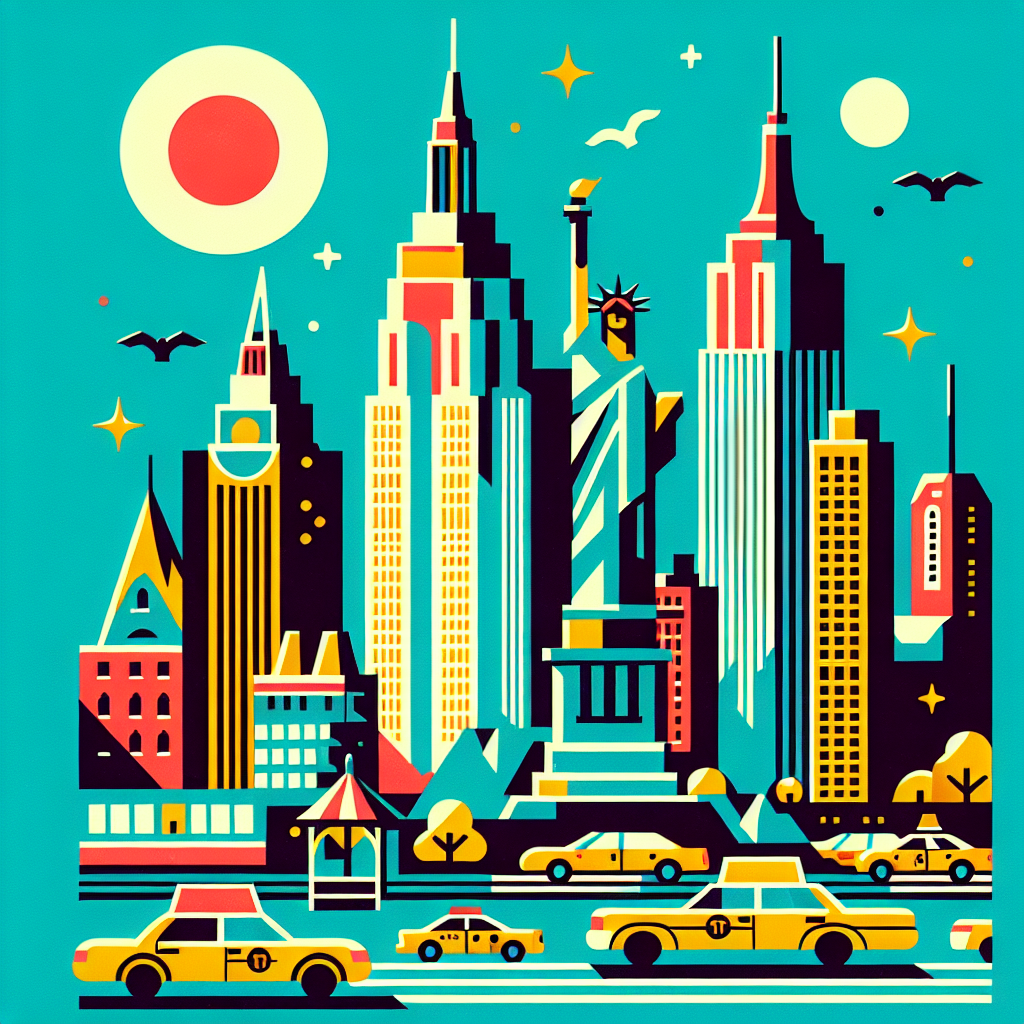

In [9]:
image = artist("New York City")
display(image)

In [ ]:
def talker(message):
    response = openai.audio.speech.create(
      model="gpt-4o-mini-tts",
      voice="onyx",    # Also, try replacing onyx with alloy or coral
      input=message
    )
    return response.content

## Let's bring this home:

1. A multi-modal AI assistant with image and audio generation
2. Tool callling with database lookup
3. A step towards an Agentic workflow


In [ ]:
def chat(history):
    history = [{"role":h["role"], "content":h["content"]} for h in history]
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    cities = []
    image = None

    while response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        responses, cities = handle_tool_calls_and_return_cities(message)
        messages.append(message)
        messages.extend(responses)
        response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    voice = talker(reply)

    if cities:
        image = artist(cities[0])
    
    return history, voice, image


In [ ]:
def handle_tool_calls_and_return_cities(message):
    responses = []
    cities = []
    for tool_call in message.tool_calls:
        if tool_call.function.name == "get_ticket_price":
            arguments = json.loads(tool_call.function.arguments)
            city = arguments.get('destination_city')
            cities.append(city)
            price_details = get_ticket_price(city)
            responses.append({
                "role": "tool",
                "content": price_details,
                "tool_call_id": tool_call.id
            })
    return responses, cities

## The 3 types of Gradio UI

`gr.Interface` is for standard, simple UIs

`gr.ChatInterface` is for standard ChatBot UIs

`gr.Blocks` is for custom UIs where you control the components and the callbacks

In [ ]:
# Callbacks (along with the chat() function above)

def put_message_in_chatbot(message, history):
        return "", history + [{"role":"user", "content":message}]

# UI definition

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500, interactive=False)
    with gr.Row():
        audio_output = gr.Audio(autoplay=True)
    with gr.Row():
        message = gr.Textbox(label="Chat with our AI Assistant:")

# Hooking up events to callbacks

    message.submit(put_message_in_chatbot, inputs=[message, chatbot], outputs=[message, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, audio_output, image_output]
    )

ui.launch(inbrowser=True, auth=("ed", "bananas"))

# Exercises and Business Applications

Add in more tools - perhaps to simulate actually booking a flight. A student has done this and provided their example in the community contributions folder.

Next: take this and apply it to your business. Make a multi-modal AI assistant with tools that could carry out an activity for your work. A customer support assistant? New employee onboarding assistant? So many possibilities! Also, see the week2 end of week Exercise in the separate Notebook.

<table style="margin: 0; text-align: left;">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/thankyou.jpg" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#090;">I have a special request for you</h2>
            <span style="color:#090;">
                My editor tells me that it makes a HUGE difference when students rate this course on Udemy - it's one of the main ways that Udemy decides whether to show it to others. If you're able to take a minute to rate this, I'd be so very grateful! And regardless - always please reach out to me at ed@edwarddonner.com if I can help at any point.
            </span>
        </td>
    </tr>
</table>